# AWS DeepRacer Track Obstacle Configuration

This notebook walks through how you can configure the obstacles on the track


1. Place the obstacles on the track
2. Visualize the obstacles on the track


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown
from markdown_helper import generate_s3_write_permission_for_sagemaker_role
%matplotlib inline

In [2]:
!pip install shapely

In [3]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

## Specify the track name
Remember to upload the corresponding tracks .npy file into ./tracks/ folder.
The file name should match the ```TRACK_NAME```

In [4]:
TRACK_NAME = "Spain_track"

In [5]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)

waypoints = get_track_waypoints(TRACK_NAME) ### Spain_track

center_line_waypoint = waypoints[:,0:2] 
inner_border_waypoint = waypoints[:,2:4]
outer_border_waypoint = waypoints[:,4:6]

In [6]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

## This gives an idea of how the track looks like and start position
The below graphs shows the waypoint numbers for the center, inner and outter lane. Zero specifies the start of the track. The increasing order specify in which direction the race is starting (clockwise or anti-clockwise).


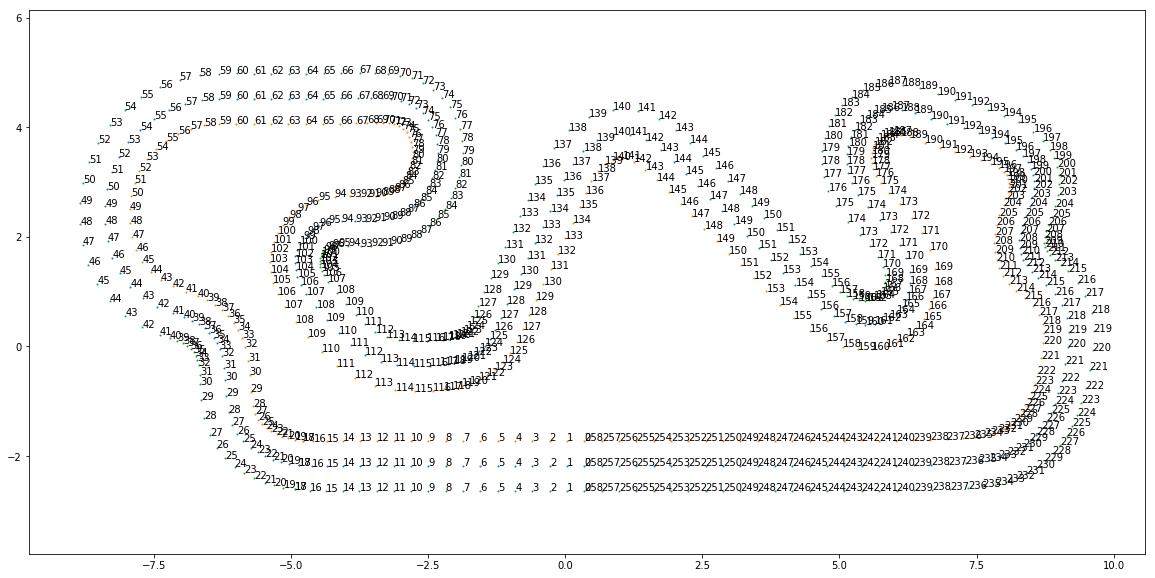

In [7]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, center_line_waypoint)
plot_points(ax, inner_border_waypoint)
plot_points(ax, outer_border_waypoint)
ax.axis('equal')
plt.show()

In [8]:
from enum import Enum, unique
    
class TrackLine(object):
    def __init__(self, line):
        self.line = line
        self.ndists = [self.line.project(Point(p), normalized=True)
                       for p in self.line.coords[:-1]] + [1.0]

    def __getattr__(self, name):
        return getattr(self.line, name)

    def interpolate_pose(self, distance, normalized=False):
        position = self.interpolate(distance, normalized)
        return (position.x, position.y)

In [9]:
inner_border_polygon = TrackLine(LinearRing(inner_border_waypoint))
center_line_polygon = TrackLine(LinearRing(center_line_waypoint))
outer_border_polygon = TrackLine(LinearRing(outer_border_waypoint))

In [10]:
def get_obstacle_xy_points(object_positions):
    inner_lane = TrackLine(LinearRing((inner_border_waypoint + center_line_waypoint)/2))
    outer_lane = TrackLine(LinearRing((outer_border_waypoint + center_line_waypoint)/2))
    lane_choices = (inner_lane, outer_lane)

    obstacle_points = []

    for object_location in object_positions:
        # index 0 is obstacle_ndist and index 1 is obstacle_lane
        obstacle_dist = object_location[0] * center_line_polygon.length
        # Inner lane is 1, outer lane is -1. If True, use outer lane
        obstacle_lane = lane_choices[object_location[1] == -1]
        x, y = obstacle_lane.interpolate_pose(obstacle_lane.project(center_line_polygon.interpolate(obstacle_dist)))
        obstacle_points.append([x, y])
    return obstacle_points

def get_start_xy_points():
    start_x, start_y = center_line_polygon.interpolate_pose(
        center_line_polygon.project(center_line_polygon.interpolate(0)))
    return (start_x, start_y)



## Specify the object position

### Example for specifying the object position

```
OBJECT_POSITIONS = [
     [0.12, 1]
    ,[0.26,  1]
    ,[0.41, -1]
    ,[0.58, +1]
    ,[0.68, -1]
    ,[0.95, +1]
]
```

![How training works](./ObstacleLocation.png)

Here each row represents one object location. 

* The first value represents the distance from the start of the track. This value is between 0.0 to 1.0. You can think of it as a percentage. If its 0.5, then the object is placed at 50% distance from the start of the track.

* The second value represents whether the object is to kept in the inner lane or the outter lane.
 * -1 represents outter lane
 * +1 represents inner lane

* The red color 'X' represents the object location on the track

* The green color 'o' represents the start location of the track. The direction can be found from the way points increasing order.

In [21]:
OBJECT_POSITIONS = [
     [0.12, -1]
    ,[0.26,  1]
    ,[0.41, -1]
    ,[0.58, +1]
    ,[0.68, -1]
    ,[0.95, +1]
]

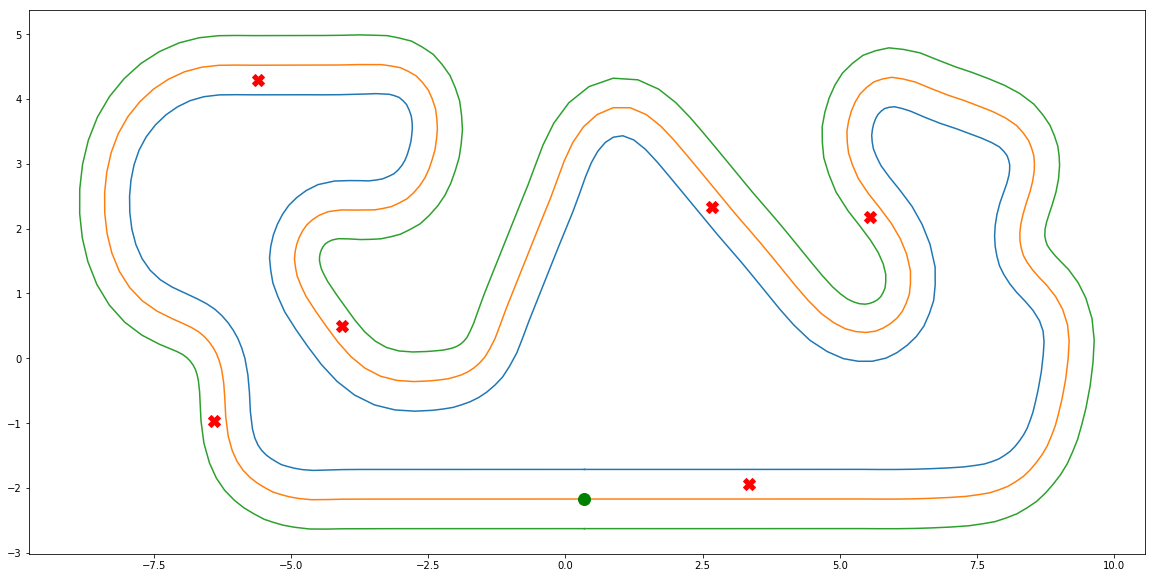

In [22]:
x_inner, y_inner = inner_border_polygon.xy
x_center, y_center = center_line_polygon.xy
x_outer, y_outer = outer_border_polygon.xy

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x_inner, y_inner)
plt.plot(x_center, y_center)
plt.plot(x_outer, y_outer)
for x, y in get_obstacle_xy_points(OBJECT_POSITIONS):
    plt.plot(x, y, color='red', marker='X', linewidth=2, markersize=12)
start_x, start_y = get_start_xy_points()
plt.plot(start_x, start_y, color='green', marker='o', linewidth=2, markersize=12)
plt.show()

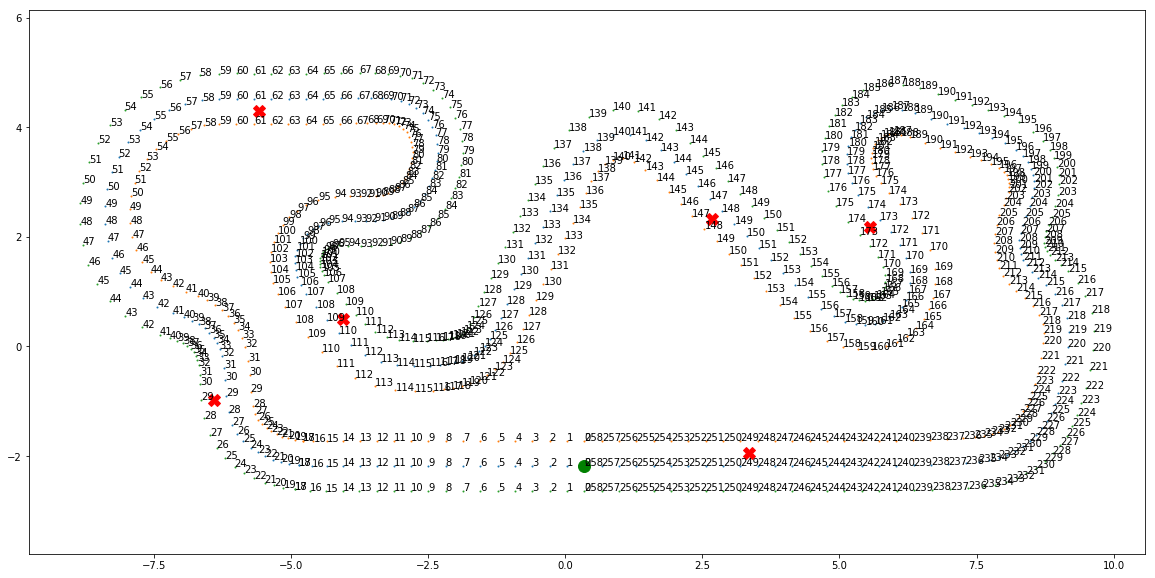

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, center_line_waypoint)
plot_points(ax, inner_border_waypoint)
plot_points(ax, outer_border_waypoint)
for x, y in get_obstacle_xy_points(OBJECT_POSITIONS):
    plt.plot(x, y, color='red', marker='X', linewidth=2, markersize=12)
start_x, start_y = get_start_xy_points()
plt.plot(start_x, start_y, color='green', marker='o', linewidth=2, markersize=12)
ax.axis('equal')
plt.show()